In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Movie ratings dataset
movieDict = {'movieID':[],'userID':[],'rating':[]}
with open('combined_data_1.txt', 'r') as inFile:
    curMovie = 0
    for line in inFile.readlines():
        if len(line.split(":")) == 2:
            curMovie = int(line.strip(':\n'))
        else:
            splitLine = line.split(",")
            lineVals = [int(splitLine[0].strip()), int(splitLine[1].strip())]
            movieDict['movieID'].append(curMovie)
            movieDict['userID'].append(lineVals[0])
            movieDict['rating'].append(lineVals[1])

In [3]:
# Movie titles dataset
movieInfo = {'movieID':[], 'Year':[], 'Title':[]}
with open('movie_titles.csv', 'r') as movieInd:
    for line in movieInd.readlines():
        curLine = line.split(',')
        if(curLine[1].strip()=='NULL'):
            continue
        formattedLine = [int(curLine[0].strip()), int(curLine[1].strip()), curLine[2].strip()]
        movieInfo['movieID'].append(formattedLine[0])
        movieInfo['Year'].append(formattedLine[1])
        movieInfo['Title'].append(formattedLine[2])

In [4]:
# Generate dataframe for movieInfo
titles_df = pd.DataFrame(movieInfo)
del movieInfo

In [5]:
titles_df.head()

,movieID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [6]:
# Generate dataframe for movieDict
movies_df = pd.DataFrame(movieDict)
del movieDict

In [7]:
movies_df.head()

,movieID,userID,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [8]:
df = movies_df[:5000000] # Using 5 million ratings due to memory and training time
users = df.groupby('userID') # Group ratings by userID

In [9]:
users.first().head()

,movieID,rating
userID,,
6,30,3
7,8,5
10,175,3
25,178,3
33,197,4


In [10]:
# Generate a 2D list of all user ratings where each row is a unique userID and the columns are
# the movie ratings at the corresponding movieID column index
num_users, total_users = 20000, 20000 # Using a smaller user sample size due to memory and training time
ratings_list = []
for _, curUser in users:
    current_ratings = [0] * df['movieID'].nunique() # Initializing array to all 0s for entries without ratings
    for _, movie in curUser.iterrows():
        current_ratings[movie['movieID']-1] = round(movie['rating']/5.0, 1) # Normalize to between 0 and 1
    ratings_list.append(current_ratings)
    num_users -= 1
    if num_users == 0:
        break

In [11]:
# Initializing variables
visibleNodes = df['movieID'].nunique() # Number of visible variables is the number of unique movies
visibleBias = tf.placeholder(tf.float32, [visibleNodes]) # Visible biases have same dimensions as visible variables
visibleBias0, visibleBias1 = np.zeros([visibleNodes]), np.zeros([visibleNodes]) # Before and after updates
hiddenNodes = 20 # Number of hidden variables (about 20 movie genres)
hiddenBias = tf.placeholder(tf.float32, [hiddenNodes]) # Hidden biases have same dimensions as hidden variables
hiddenBias0, hiddenBias1 = np.zeros([hiddenNodes]), np.zeros([hiddenNodes]) # Before and after updates
weights = tf.placeholder(tf.float32, [visibleNodes, hiddenNodes]) # Weights dimensions must match in matrix multiplication
weights0, weights1 = np.zeros([visibleNodes, hiddenNodes]), np.zeros([visibleNodes, hiddenNodes]) # Before and after updates

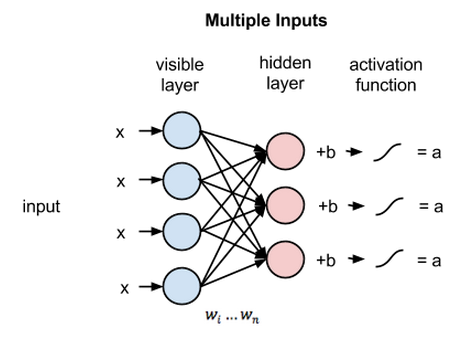

In [12]:
Image(filename='Capture.png')

In [13]:
# Multiple Inputs Phase
visibleLayer = tf.placeholder(tf.float32, [None, visibleNodes]) # Visible layer allocation
hiddenLayer = tf.nn.sigmoid(tf.matmul(visibleLayer, weights) + hiddenBias) # Hidden layer = x * w + b
hiddenReLU = tf.nn.relu(tf.sign(hiddenLayer - tf.random_uniform(tf.shape(hiddenLayer))))

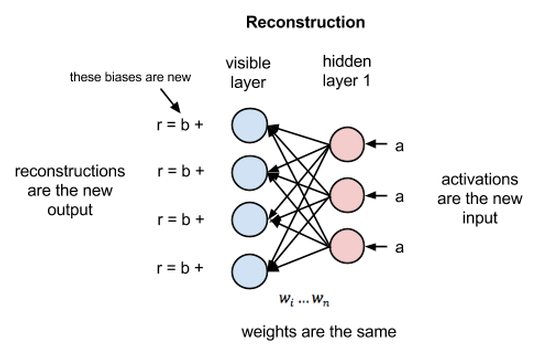

In [14]:
Image(filename='Capture2.png')

In [15]:
# Reconstruction Phase
visibleRecon = tf.nn.sigmoid(tf.matmul(hiddenReLU, tf.transpose(weights)) + visibleBias)
visibleReLU = tf.nn.relu(tf.sign(visibleRecon - tf.random_uniform(tf.shape(visibleRecon))))
hiddenRecon = tf.nn.sigmoid(tf.matmul(visibleReLU, weights) + hiddenBias)

In [16]:
# https://en.m.wikipedia.org/wiki/Restricted_Boltzmann_machine#Training_algorithm

# The positive gradient is defined as the outer product of the training sample
# and the hidden activation vector
positive_grad = tf.matmul(tf.transpose(visibleLayer), hiddenReLU)

# The negative gradient is defined as the outer product of the reconstruction
# of the training sample and the reconstruction of the hidden activation vector
negative_grad = tf.matmul(tf.transpose(visibleReLU), hiddenRecon)

# Update steps
# Weights are updated by: learning rate*(pos_grad-neg_grad)
lr = 0.1 # Learning rate
update_weights = lr * (positive_grad - negative_grad) + weights

# Update visible and hidden biases: learning rate*(input-reconstructed)
update_visibleBias = lr * tf.reduce_mean(visibleLayer - visibleReLU, axis=0) + visibleBias # Take the mean to match dimensions
update_hiddenBias = lr * tf.reduce_mean(hiddenLayer - hiddenRecon, axis=0) + hiddenBias

In [17]:
# Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
epochs = 10
batchsize = 100
for i in range(epochs):
    print("Epoch:", i+1, "of", epochs)
    for j in range(0, len(ratings_list), batchsize):
        batch = ratings_list[j:j+batchsize]
        weights1 = sess.run(update_weights, feed_dict={visibleLayer: batch, weights: weights0, visibleBias: visibleBias0, hiddenBias: hiddenBias0})
        visibleBias1 = sess.run(update_visibleBias, feed_dict={visibleLayer: batch, weights: weights0, visibleBias: visibleBias0, hiddenBias: hiddenBias0})
        hiddenBias1 = sess.run(update_hiddenBias, feed_dict={visibleLayer: batch, weights: weights0, visibleBias: visibleBias0, hiddenBias: hiddenBias0})
        weights0, visibleBias0, hiddenBias0 = weights1, visibleBias1, hiddenBias1

Epoch: 1 of 10
Epoch: 2 of 10
Epoch: 3 of 10
Epoch: 4 of 10
Epoch: 5 of 10
Epoch: 6 of 10
Epoch: 7 of 10
Epoch: 8 of 10
Epoch: 9 of 10
Epoch: 10 of 10


In [18]:
# Pick a random user to recommend movies (or choose your own index)
rand_user = np.random.randint(total_users)
user = [ratings_list[rand_user]]

In [20]:
# Reconstruction for chosen user
hidden = sess.run(hiddenRecon, feed_dict={visibleReLU: user, weights: weights0, hiddenBias: hiddenBias0})
visibleReconstruction = sess.run(visibleRecon, feed_dict={hiddenReLU: hidden, weights: weights0, visibleBias: visibleBias0})

In [21]:
# Create the dataframe for the movies recommended
pd.set_option('mode.chained_assignment', None)
user_df = titles_df[:max(df['movieID'])]
user_df['Score'] = visibleReconstruction[0]
user_df = user_df.round(5).drop(['movieID','Year'], axis=1).sort_values(by=['Score'], ascending=False)
user_df = user_df.rename_axis('movieID', axis='columns')

In [22]:
num_rec = 10 # How many movies to recommend
user_df.head(num_rec) # Display the top num_rec movies

movieID,Title,Score
570,American Beauty,0.63781
174,Reservoir Dogs,0.58579
311,High Fidelity,0.55313
481,Frida,0.49007
885,Ray,0.44611
797,Jaws,0.44463
240,North by Northwest,0.44173
787,Clerks,0.43447
328,Dogma,0.39544
719,Roger & Me,0.37253
